# Projet 2: Concevez une application au service de la santé publique
## Notebook d'analyse des données
## Analyse bi et multivariée

### Chargement des modules python

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, preprocessing
import seaborn as sns

### fonctions utiles

#### Fonctions pour les floats

In [2]:
def is_lower(value, target=np.inf) :
    """
    function to verify if the value is lower of the target value
    parameters : value : float 
                 target : float
    returns : value if the value is lower than the target,
              np.NaN if the value is higher
    """
    if pd.notnull(value) :
        if value <= target :
            return value
        else :
            print(f"{value} is higher than the target {target}")
            return np.NaN
    else :
        return np.NaN

In [3]:
def is_higher(value, target=-np.inf) :
    """
    function to verify if the value is higher of the target value
    parameters : value : float 
                 target : float
    returns : value if the value is higher than the target,
              np.NaN if the value is lower
    """
    if pd.notnull(value) :
        if value >= target :
            return value
        else :
            print(f"{value} is lower than the target {target}")
            return np.NaN
    else :
        return np.NaN

#### fonctions pour les listes

In [4]:
def remove_lists(df, column=None) :
    if column not in df.columns :
        raise ValueError(f"{columns} is not a column of the dataframe")
    odf = pd.DataFrame(columns = df.columns)
    for i in range(0, len(df)):
        line = df.iloc[i]
        if len(line[column]) == 0:
            line[column] = np.NaN
            odf = odf.append(line)
        else :
            for val in line[column] :
                oline = line
                oline[column] = val
                odf = odf.append(oline)
    return odf

In [5]:
def create_list(value) :
    """
    function to create list from str chains
    if the type of value is not str, return empty list
    
    parameters : value : str
    
    returns : list
    """
    if type(value) == str :
        if value.startswith("[") :
            value = value[1:]
        if value.endswith(']') :
            value = value[:-1]
        return value.split(',')
    elif (type(value) == int or type(value) == float) and pd.notnull(value) :
        print(f"Type of {value} is {type(value)} : not expected => ignored ")
        return []
    else :
        return []

#### fonctions pour la représentation graphique

In [6]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """
    extracted from OC courses 
    """
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        

In [8]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    """
    extracted from OC courses
    """
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [9]:
def display_scree_plot(pca):
    """
    extracted form OC courses
    """
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

#### fonctions pour les modifications de variables

In [10]:
def carbon_grade(value) :
    """
    function to define a carbon grade. 
    the carbon grade is a value between a and e, function of the carbon-footprint.
    The grade is that of the "loi climat" in France.
    
    parameters : value : float or int 
                    carbon-footprint
    return : str 
                str between a and e
    """
    if type(value) in [float, int] :
        if pd.notnull(value) :
            if value <= 80 :
                return "a"
            elif value <= 180 :
                return "b"
            elif value <= 330 :
                return "c"
            elif value <= 530 :
                return "d"
            else :
                return "e"
        else :
            return np.NaN
    else :
        print(f"Value of type {type(value)} has not a carbon grade")
        return np.NaN

In [11]:
def is_filled(value) :
    """
    function to indicate if a value is filled or not
    parameters : value : str, float, int or list
    returns : Bool 
    """
    if type(value) in [str, float, int] :
        return pd.notnull(value)
    elif type(value) == list :
        return len(value) > 0
    else :
        print(f"Variable of type {type(value)} is not supported")

In [12]:
def int2grade(value) :
    """
    function to convert a int to a grade in letter
    parameters : int 
    return : str
    """
    letters = ["a","b","c","d","e"]
    if pd.notnull(value) :
        return letters[int(value)]
    else :
        return np.NaN   

In [13]:
def grade2int(value) :
    """
    function to convert a letter to a integer
    parameters : str
    return : int
    """
    letters = ["a","b","c","d","e"]
    if pd.notnull(value) :
        return letters.index(value)
    else :
        return np.NaN    

#### Fonctions pour ANOVA

In [14]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

### Chargement du dataset nettoyé

In [15]:
DATA_FILE = "database_cleaned.csv"
if os.path.isfile(DATA_FILE) :
    DATA = pd.read_csv(DATA_FILE, sep=";", low_memory=False)
else :
    raise ValueError(f"{DATA_FILE} is not a file")
    
#recréation des variables listes
for col in ['categories_tags', 'origins_tags', 'manufacturing_places_tags'] :
    DATA[col] = DATA[col].apply(create_list)

### Suppression des outliers (voir analyse univariée)

In [16]:
DATA["energy_100g"] = DATA["energy_100g"].apply(is_lower, target=5000)
DATA["saturated-fat_100g"] = DATA["saturated-fat_100g"].apply(is_lower, target=60)
DATA["carbon-footprint_100g"] = DATA["carbon-footprint_100g"].apply(is_lower, target=2000)

5690.0 is higher than the target 5000
5439.0 is higher than the target 5000
10757.0 is higher than the target 5000
6975.0 is higher than the target 5000
6276.0 is higher than the target 5000
13213.0 is higher than the target 5000
6694.0 is higher than the target 5000
6694.0 is higher than the target 5000
14644.0 is higher than the target 5000
5577.0 is higher than the target 5000
5054.0 is higher than the target 5000
10966.0 is higher than the target 5000
11954.0 is higher than the target 5000
5577.0 is higher than the target 5000
5577.0 is higher than the target 5000
6849.0 is higher than the target 5000
110579.0 is higher than the target 5000
6975.0 is higher than the target 5000
14347.0 is higher than the target 5000
94140.0 is higher than the target 5000
8523.0 is higher than the target 5000
8523.0 is higher than the target 5000
5439.0 is higher than the target 5000
6276.0 is higher than the target 5000
5577.0 is higher than the target 5000
7012.0 is higher than the target 5000
268

60.4 is higher than the target 60
61.0 is higher than the target 60
61.0 is higher than the target 60
61.0 is higher than the target 60
68.0 is higher than the target 60
86.0 is higher than the target 60
63.0 is higher than the target 60
87.0 is higher than the target 60
84.0 is higher than the target 60
87.0 is higher than the target 60
100.0 is higher than the target 60
65.0 is higher than the target 60
93.0 is higher than the target 60
93.0 is higher than the target 60
75.0 is higher than the target 60
93.0 is higher than the target 60
93.0 is higher than the target 60
66.0 is higher than the target 60
63.0 is higher than the target 60
65.6 is higher than the target 60
80.0 is higher than the target 60
65.0 is higher than the target 60
87.0 is higher than the target 60
87.0 is higher than the target 60
64.0 is higher than the target 60
63.5 is higher than the target 60
74.0 is higher than the target 60
61.1 is higher than the target 60
63.5 is higher than the target 60
85.0 is highe

### Nouvelles variables

In [17]:
DATA['carbon_grade'] = DATA['carbon-footprint_100g'].apply(carbon_grade)

for col in ['categories_tags', 'origins_tags', 'manufacturing_places_tags'] :
    DATA['nb_'+col] = DATA[col].apply(len)
    

In [18]:
SIZE = len(DATA)
N_VAR = len(DATA.columns)
print(f"Number of lines     = {SIZE}")
print(f"Number of variables = {N_VAR}")
print(f"Variables           = {', '.join(DATA.columns)}")

Number of lines     = 320772
Number of variables = 21
Variables           = code, url, product_name, categories_tags, nutrition_grade_fr, carbon-footprint_100g, origins_tags, manufacturing_places_tags, additives_n, energy_100g, fat_100g, saturated-fat_100g, fruits-vegetables-nuts_100g, sodium_100g, sugars_100g, pnns_groups_1, pnns_groups_2, carbon_grade, nb_categories_tags, nb_origins_tags, nb_manufacturing_places_tags


### Relation entre le carbone score et le nutriscore?

In [19]:
X = "carbon_grade"
Y = "nutrition_grade_fr"
cont = DATA[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len, margins=True,margins_name="Total")
cont

nutrition_grade_fr,a,b,c,d,e,Total
carbon_grade,,,,,,
a,20,12,13,8,3,56
b,9,3,7,10,20,49
c,16,3,9,14,8,50
d,4,7,12,6,3,32
e,3,2,3,14,17,39
Total,52,27,44,52,51,226


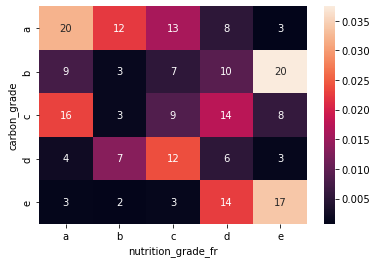

In [21]:
x = cont.loc[:,["Total"]]
y = cont.loc[["Total"],:]
indep = x.dot(y)/len(DATA)
measure = (cont-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=cont.iloc[:-1,:-1])
plt.show()

Il semble exister une faible relation entre les 2 variables.  
Les produits avec un bon nutriscore ont tendance à avoir un bon carbone score.  
Et inversement.

### Analyse entre variables qualitiatives et quantitative : ANOVA
#### Analyse entre PNNS_groups_1 et une variable quantitative

------------------------------------------------------------
          | pnns_groups_1 / energy_100g |


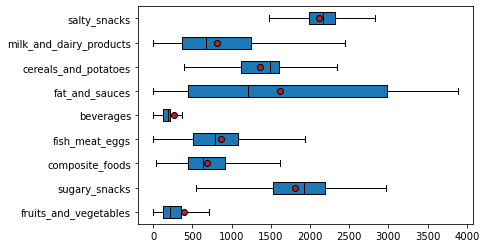

eta_squared = 0.51
------------------------------------------------------------
          | pnns_groups_1 / carbon-footprint_100g |


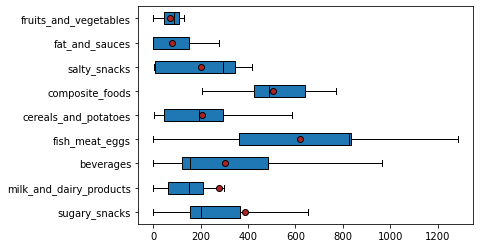

eta_squared = 0.17
------------------------------------------------------------
          | pnns_groups_1 / fat_100g |


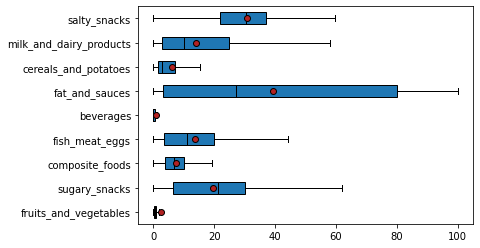

eta_squared = 0.35


In [22]:
for X, Y in [("pnns_groups_1", "energy_100g"), ("pnns_groups_1", "carbon-footprint_100g"), 
                    ("pnns_groups_1", "fat_100g")] :
    print("-"*60)
    print(' '*10+"="*(len(X)+len(Y)+6))
    print(' '*10+"| "+X+' / '+Y+' |')
    print(' '*10+"="*(len(X)+len(Y)+6))
    data = DATA[pd.notnull(DATA[X])]
    data = data[pd.notnull(data[Y])]

    modalites = data[X].unique()
    groupes = []
    for mod in modalites : 
        groupes.append(data[data[X]==mod][Y])    
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
    plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()

    #Calcul du eta squared (correlation entre X et Y)

    print(f"eta_squared = {eta_squared(data[X],data[Y]):.2f}")


- Les catégories de produits et l'apport calorifique sont les variables les plus corrélées. 
- A l'inverse les catégories de produits et l'empreinte carbone semblent totalement décorrélées.

#### Analyse entre le nutriscore et une variable quantitative  
Le nutriscore est une variable qualitative ordinale, on peut donc la considérer comme un int.

------------------------------------------------------------
          | nutrition_grade_fr / energy_100g |


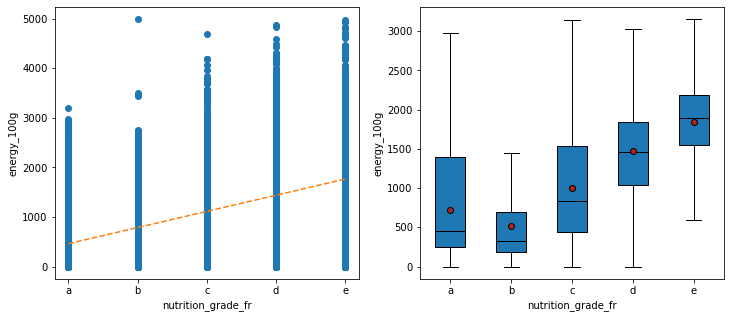

coefficient de correlation =  0.333
eta_squared = 0.379
------------------------------------------------------------
          | nutrition_grade_fr / carbon-footprint_100g |


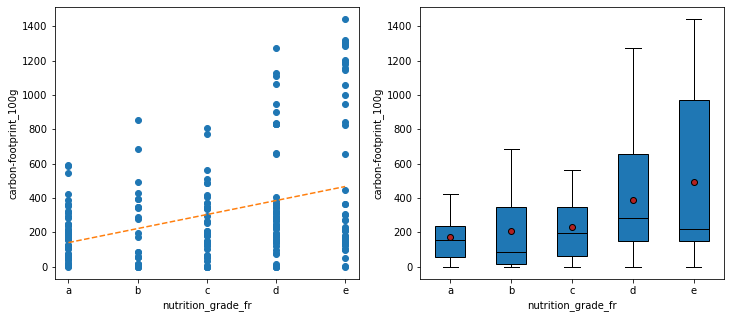

coefficient de correlation =  0.129
eta_squared = 0.143
------------------------------------------------------------
          | nutrition_grade_fr / fat_100g |


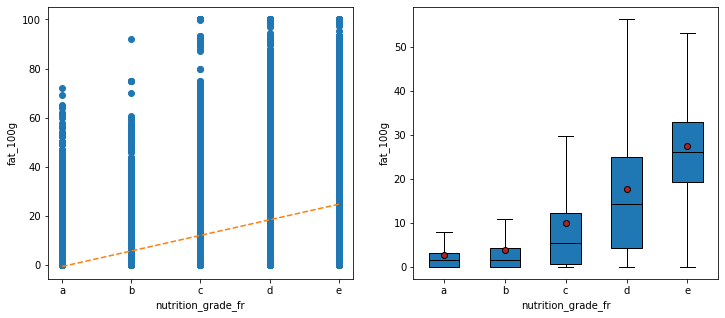

coefficient de correlation =  0.283
eta_squared = 0.301


In [24]:
for var1, var2 in [("nutrition_grade_fr", "energy_100g"), ("nutrition_grade_fr", "carbon-footprint_100g"), 
                    ("nutrition_grade_fr", "fat_100g")] :
    print("-"*60)
    print(' '*10+"="*(len(var1)+len(var2)+6))
    print(' '*10+"| "+var1+' / '+var2+' |')
    print(' '*10+"="*(len(var1)+len(var2)+6))
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
    data = DATA[[var1, var2]]
    data = data.dropna()
    data["nutrition_grade_fr"] = data["nutrition_grade_fr"].apply(grade2int)

    X = data[var1].values.reshape(-1,1)
    Y = data[var2].values.reshape(-1,1)

    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    score = regr.score(X, Y)
    fit = [np.arange(0,5), regr.predict(np.arange(0,5).reshape((-1,1)))]
    ax1.plot(DATA['nutrition_grade_fr'].apply(grade2int), DATA[var2], linestyle=' ', marker="o")
    ax1.plot(fit[0], fit[1], linestyle='--')
    ax1.set_xlabel(var1)
    ax1.set_ylabel(var2)
    ax1.set_xticks(np.arange(0,5))
    ax1.set_xticklabels(["a",'b','c','d','e'])

    #boxplot
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
                'markerfacecolor':'firebrick'}
    modalites = np.unique(X)
    groupes = []
    for mod in modalites :
        groupes.append(Y[X==mod])
    ax2.boxplot(groupes, labels=['a','b','c','d','e'], showfliers=False, medianprops=medianprops,
               patch_artist=True, showmeans=True, meanprops=meanprops)
    ax2.set_xlabel(var1)
    ax2.set_ylabel(var2)
    plt.show()
    print(f"coefficient de correlation =  {score:.3f}")
    print(f"eta_squared = {eta_squared(data[var1],data[var2]):.3f}")

### ACP
Rechercher des correlations entre les variables quantitatives du dataset.  
les variables séléctionnées sont :  
- additives_n   
- energy_100g  
- fat_100g  
- saturated-fat_100g  
- sodium_100g
- sugar_100g
- nutrition_grade_fr  (transformé en int)

l'empreinte carbone et fruits-vegetables-nuts_100g ne sont séléctionnées car il y a trop peu de données.  
Dans un premier temps, uniquement les produits complétement remplis sont utiliséset donc aucune impuation n'est réalisée.  
Pour aller plus loin, il peut être envisagé d'effectué une imputation par la médiane pour les valeurs manquantes,  
ou d'estimer les valeurs à partir des K plus proches voisins.

In [25]:
DATA["nutrition_grade_fr_int"] = DATA["nutrition_grade_fr"].apply(grade2int)
selected_cols = ['additives_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
                'sodium_100g', 'sugars_100g', "nutrition_grade_fr_int"]
df = DATA[selected_cols]
df = df.dropna()
X = df.values
labels = df.columns
n_comp = len(labels)-1
print(f"Nombre de données utilisé pour l'analyse en composantes principales = {len(df)}")
print(f"Nombre de variables utilisé pour l'analyse en composantes principales = {len(labels)}")
print(f"Nombre de composantes calculées = {n_comp}")
df.head()

Nombre de données utilisé pour l'analyse en composantes principales = 194932
Nombre de variables utilisé pour l'analyse en composantes principales = 7
Nombre de composantes calculées = 6


,additives_n,energy_100g,fat_100g,saturated-fat_100g,sodium_100g,sugars_100g,nutrition_grade_fr_int
1,0.0,2243.0,28.57,28.57,0.000,14.29,3.0
2,0.0,1941.0,17.86,0.00,0.250,17.86,1.0
3,0.0,2540.0,57.14,5.36,0.482,3.57,3.0
7,2.0,1833.0,18.75,4.69,0.055,15.62,2.0
12,1.0,2230.0,36.67,5.00,0.633,3.33,3.0


Afin d'analyser plus facilement les projections sur les plans factoriels, des données correctement catégorisées sont sélectionnées pour les placer.  
un faible nombre de données est selectionnées pour simplifier la visualisation.

In [27]:
n_test = 200
df_test = DATA[['pnns_groups_1']+selected_cols]
df_test = df_test.dropna()
i = np.random.randint(low=0, high=len(df_test), size=n_test)
df_test = df_test.iloc[i]
X_test = df_test[selected_cols].values
labels_test = df_test.columns
df_test.head()

,pnns_groups_1,additives_n,energy_100g,fat_100g,saturated-fat_100g,sodium_100g,sugars_100g,nutrition_grade_fr_int
248908,fish_meat_eggs,1.0,1703.0,38.7,13.85,0.530000,0.0,4.0
225508,milk_and_dairy_products,1.0,686.0,14.6,9.80,0.043307,3.5,3.0
294500,sugary_snacks,17.0,1095.0,15.0,12.00,0.137795,19.0,3.0
227741,cereals_and_potatoes,2.0,722.0,8.0,4.80,0.244094,0.5,2.0
227667,milk_and_dairy_products,0.0,397.0,3.4,2.40,0.039370,12.0,2.0


In [28]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
X_test_scaled = std_scale.transform(X_test)

pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

pcs = pca.components_

#### affichage du diagramme des éboulis

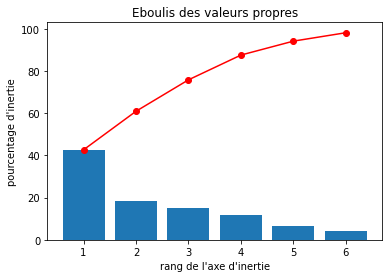

In [29]:
display_scree_plot(pca)

La courbe de la somme des inerties représentées par chaque axes progresse lentement.  
Cela signifie qu'il est nécessaire d'étudier aux moins les 4 premiers axes pour rendre compte de 80% de l'inertie.

#### Affichage des cercles de corrélations

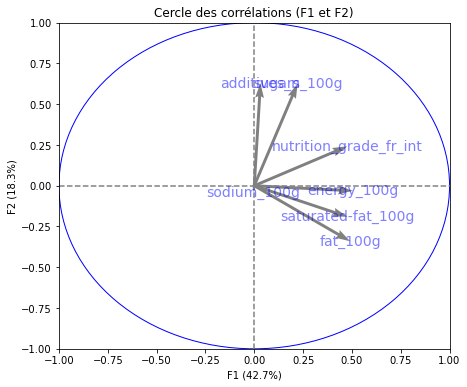

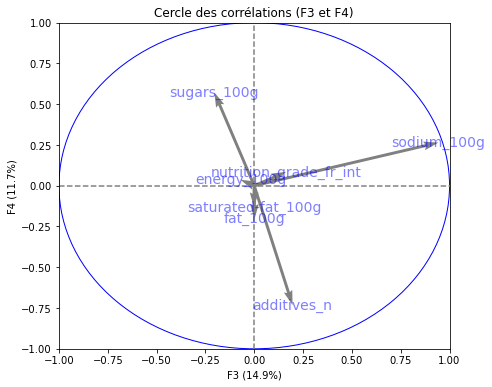

In [30]:
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(labels))

#### Projections du nuages des individus sur les plans factoriels

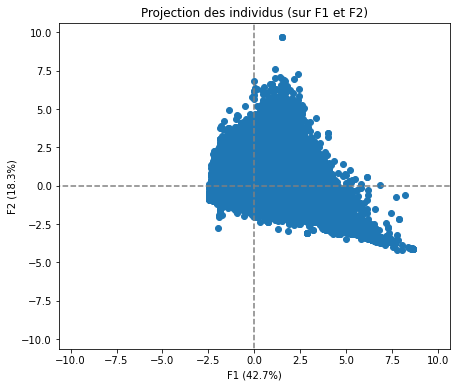

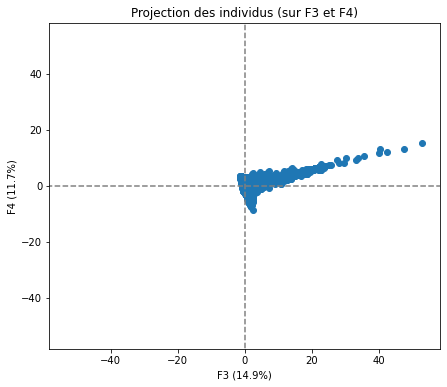

In [31]:
X_projected = pca.transform(X_scaled) 
display_factorial_planes(X_projected, n_comp, 
                         pca, [(0,1),(2,3)])

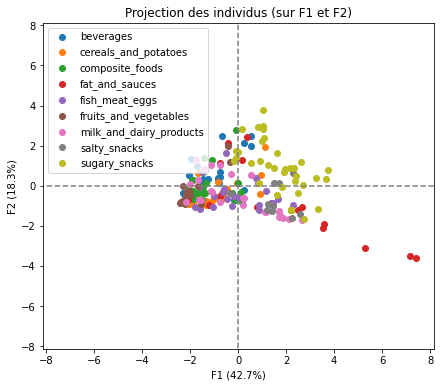

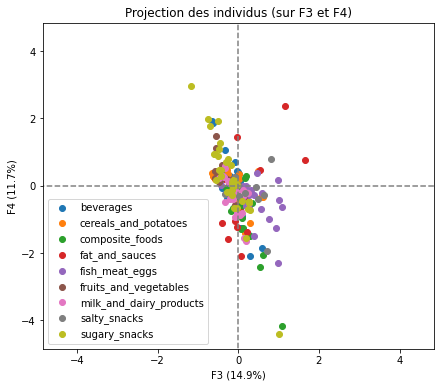

In [32]:
X_test_projected = pca.transform(X_test_scaled) 
display_factorial_planes(X_test_projected, n_comp, 
                         pca, [(0,1),(2,3)], illustrative_var=[df_test['pnns_groups_1']])

Plusieurs observations peuvent être effectuées à partir de cette ACP.
- l'axe F1 représente les variables le taux de graisses et l'apport calorifique
- l'axe F2 capte l'inertie des axes représentant le nombre d'additifs et le taux de sucre
- on remarque que la variable nutriscore se situe entre les deux axes. Cela semble totalement logique
- l'axe F3 capte presque uniquement l'inertie de la variable Sodium

En placant des individus catégorisés sur les plans factoriels on remarque : 
- les points sont principalement regroupés aux centres des plans factoriels. Cela provient probablement du fait que les outliers captent l'inertie sur les premiers composantes principales.
- deux catégories se détachent : les "fat and sauces" et les "sugary snacks", des catégories comportant un taux de graisse ou de sucre élévé, et donc un mauvais nutriscore. Ces observations sont captées par les axes F1 et F2.